Autoencoder is easy? Nah

In [9]:
import gpustat
gpustat.print_gpustat()
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'
import random
random.seed(0)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Concatenate, Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend as K
import seaborn as sns
sns.set(style="white", color_codes=True)
from sklearn.ensemble import GradientBoostingRegressor

import fastai
from fastai.vision import Learner, DataBunch, Callback, dataclass

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data.distributed
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

imperium-sm.hep.caltech.edu  Sun Aug  4 12:21:54 2019  418.67
[0] GeForce GTX 1080 | 38'C,   0 % |   666 /  8119 MB | 3038(655M)
[1] GeForce GTX 1080 | 22'C,   0 % |  8100 /  8119 MB | qnguyen(8089M)
[2] GeForce GTX 1080 | 26'C,   0 % |     1 /  8119 MB |
[3] GeForce GTX 1080 | 24'C,   0 % |   548 /  8119 MB | qnguyen(537M)
[4] GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |
[5] GeForce GTX 1080 | 23'C,   0 % |     1 /  8119 MB |
[6] GeForce GTX 1080 | 24'C,   0 % |     1 /  8119 MB |
[7] GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |


Let's start with a toy dataset that emulate $p_T$, $\eta$, and $\phi$. Starting with $\phi$, which in principle is a flat distribution:

(array([210., 209., 210., 209., 210., 209., 210., 209., 209., 210., 209., 210., 209., 210., 209., 209., 210., 209.,
        210., 209., 210., 209., 209., 210., 209., 210., 209., 210., 209., 210.]),
 array([-3.141593e+00, -2.932159e+00, -2.722726e+00, -2.513293e+00, -2.303859e+00, -2.094426e+00, -1.884993e+00,
        -1.675559e+00, -1.466126e+00, -1.256693e+00, -1.047259e+00, -8.378260e-01, -6.283927e-01, -4.189593e-01,
        -2.095260e-01, -9.265359e-05,  2.093407e-01,  4.187740e-01,  6.282073e-01,  8.376407e-01,  1.047074e+00,
         1.256507e+00,  1.465941e+00,  1.675374e+00,  1.884807e+00,  2.094241e+00,  2.303674e+00,  2.513107e+00,
         2.722541e+00,  2.931974e+00,  3.141407e+00]),
 <a list of 30 Patch objects>)

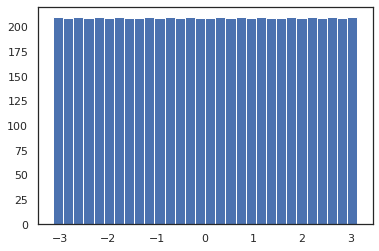

In [2]:
phi = np.arange(-np.pi,np.pi,0.001)
plt.hist(phi,bins=30)

Now let's pretend $\eta$ is some function of $\phi$:

(array([  9.,  13.,  45.,  88., 138., 258., 236., 276., 274., 300., 299., 275., 279., 300., 280., 299., 276., 287.,
        275., 286., 290., 287., 287., 296., 224., 185., 119.,  63.,  34.,   6.]),
 array([-4.277615, -3.997138, -3.716661, -3.436184, -3.155707, -2.87523 , -2.594753, -2.314276, -2.033799, -1.753322,
        -1.472845, -1.192368, -0.911891, -0.631414, -0.350937, -0.07046 ,  0.210017,  0.490495,  0.770972,  1.051449,
         1.331926,  1.612403,  1.89288 ,  2.173357,  2.453834,  2.734311,  3.014788,  3.295265,  3.575742,  3.856219,
         4.136696]),
 <a list of 30 Patch objects>)

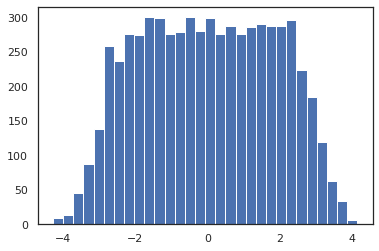

In [3]:
eta = phi + np.random.normal(-2,np.absolute(phi/10)) + np.random.normal(2,np.absolute(phi/10))
plt.hist(eta, bins=30)

And $p_T$ is some function of $\eta$

(array([398., 771., 655., 532., 411., 346., 300., 259., 223., 204., 194., 176., 152., 128., 130., 134., 121., 117.,
        116., 109., 111.,  79.,  88.,  71.,  90.,  78.,  80.,  72.,  70.,  69.]),
 array([0.083254, 0.280378, 0.477502, 0.674626, 0.87175 , 1.068874, 1.265998, 1.463122, 1.660246, 1.85737 , 2.054493,
        2.251617, 2.448741, 2.645865, 2.842989, 3.040113, 3.237237, 3.434361, 3.631485, 3.828609, 4.025733, 4.222857,
        4.419981, 4.617104, 4.814228, 5.011352, 5.208476, 5.4056  , 5.602724, 5.799848, 5.996972]),
 <a list of 30 Patch objects>)

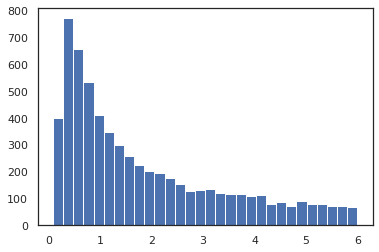

In [4]:
# Small |eta| = high pT
pt = np.exp(-np.absolute(eta))*6
plt.hist(pt, bins=30)


So far so good, let's chunk them together to create our toy dataset

In [5]:
phi = phi.reshape(-1,1)
eta = eta.reshape(-1,1)
pt = pt.reshape(-1,1)

idx = np.arange(len(phi))
np.random.shuffle(idx)
train_idx = idx[:int(len(phi)*0.8)]
val_idx = idx[int(len(phi)*0.8):]
dataset = np.concatenate((pt[train_idx],eta[train_idx],phi[train_idx]),1)
val_dataset = np.concatenate((pt[val_idx],eta[val_idx],phi[val_idx]),1)
print(dataset.shape)

class MyDataset(Dataset):
    def __init__(self, xdata, ydata):
        self.xdata = torch.from_numpy(xdata).float()
        self.ydata = torch.from_numpy(ydata).float()

    def __len__(self):
        return len(self.xdata)

    def __getitem__(self, idx):
        return self.xdata[idx], self.ydata[idx]
    
train_data = MyDataset(dataset, dataset)
train_loader = DataLoader(dataset=train_data, batch_size=1000, shuffle=True)
val_data = MyDataset(val_dataset, val_dataset)
val_loader = DataLoader(dataset=val_data, batch_size=1000, shuffle=True)


(5027, 3)


# Linear Model, MSE

In [220]:

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
        
model = MyModel()
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

for t in range(1000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = criterion(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))



Epoch 0: Loss: 5.060623645782471.
Epoch 50: Loss: 3.2655179500579834.
Epoch 100: Loss: 1.7948344945907593.
Epoch 150: Loss: 1.4323424100875854.
Epoch 200: Loss: 1.307456135749817.
Epoch 250: Loss: 1.1484861373901367.
Epoch 300: Loss: 1.1148359775543213.
Epoch 350: Loss: 1.0676095485687256.
Epoch 400: Loss: 0.8841525912284851.
Epoch 450: Loss: 0.9246156215667725.
Epoch 500: Loss: 0.8216058611869812.
Epoch 550: Loss: 0.9319902062416077.
Epoch 600: Loss: 0.8447998762130737.
Epoch 650: Loss: 0.8841612935066223.
Epoch 700: Loss: 0.7233100533485413.
Epoch 750: Loss: 0.8247567415237427.
Epoch 800: Loss: 0.7503125071525574.
Epoch 850: Loss: 0.691878080368042.
Epoch 900: Loss: 0.77344810962677.
Epoch 950: Loss: 0.7485801577568054.


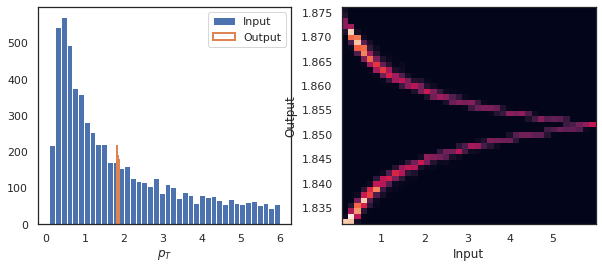

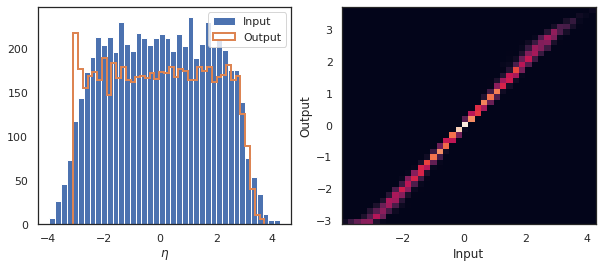

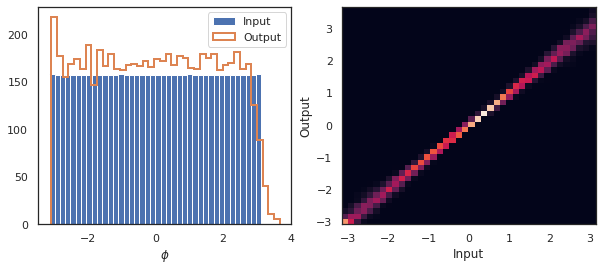

In [221]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

# Linear Model MSE -- After rerunning N times

Epoch 0: Loss: 3.581855535507202.
Epoch 50: Loss: 3.5177838802337646.
Epoch 100: Loss: 3.100940227508545.
Epoch 150: Loss: 3.070528507232666.
Epoch 200: Loss: 3.317605495452881.
Epoch 250: Loss: 2.9152097702026367.
Epoch 300: Loss: 3.0039453506469727.
Epoch 350: Loss: 2.6602718830108643.
Epoch 400: Loss: 3.077491283416748.
Epoch 450: Loss: 3.185708522796631.
Epoch 500: Loss: 2.983238935470581.
Epoch 550: Loss: 3.121546506881714.
Epoch 600: Loss: 3.1615185737609863.
Epoch 650: Loss: 2.9950151443481445.
Epoch 700: Loss: 3.1594629287719727.
Epoch 750: Loss: 3.09879207611084.
Epoch 800: Loss: 2.904749631881714.
Epoch 850: Loss: 2.9883220195770264.
Epoch 900: Loss: 2.884272813796997.
Epoch 950: Loss: 2.967571258544922.


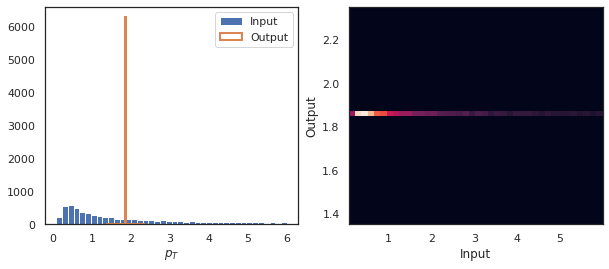

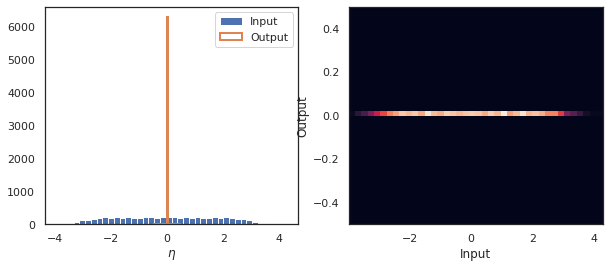

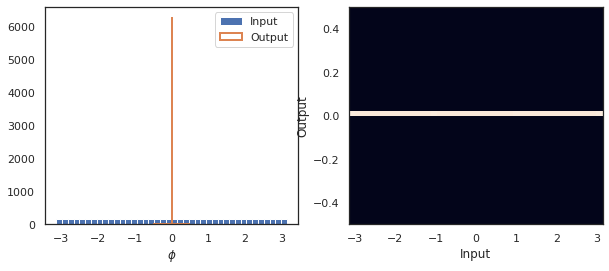

In [222]:

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
        
model = MyModel()
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

for t in range(1000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = criterion(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))

output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

# Linear Model MSE -- After rerunning N times

In [240]:

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
        
model = MyModel()
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

   
train_data = MyDataset(dataset, dataset)
train_loader = DataLoader(dataset=train_data, batch_size=1000, shuffle=True)

for t in range(2000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = criterion(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))


Epoch 0: Loss: 4.9568610191345215.
Epoch 50: Loss: 2.3459949493408203.
Epoch 100: Loss: 1.60237455368042.
Epoch 150: Loss: 1.363577127456665.
Epoch 200: Loss: 1.1176255941390991.
Epoch 250: Loss: 0.6715921759605408.
Epoch 300: Loss: 0.2594994604587555.
Epoch 350: Loss: 0.17601944506168365.
Epoch 400: Loss: 0.13328339159488678.
Epoch 450: Loss: 0.1224108338356018.
Epoch 500: Loss: 0.10927087068557739.
Epoch 550: Loss: 0.06698247045278549.
Epoch 600: Loss: 0.06329819560050964.
Epoch 650: Loss: 0.028155731037259102.
Epoch 700: Loss: 0.020587828010320663.
Epoch 750: Loss: 0.012626340612769127.
Epoch 800: Loss: 0.012954282574355602.
Epoch 850: Loss: 0.011203535832464695.
Epoch 900: Loss: 0.01088565494865179.
Epoch 950: Loss: 0.011917817406356335.
Epoch 1000: Loss: 0.011621775105595589.
Epoch 1050: Loss: 0.013143855147063732.
Epoch 1100: Loss: 0.011677134782075882.
Epoch 1150: Loss: 0.01141366083174944.
Epoch 1200: Loss: 0.009671580046415329.
Epoch 1250: Loss: 0.010496504604816437.
Epoch 130

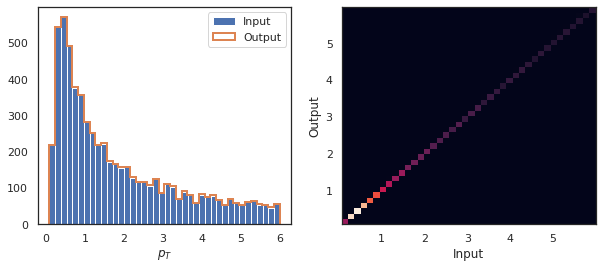

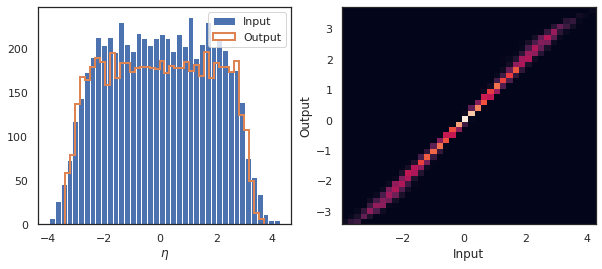

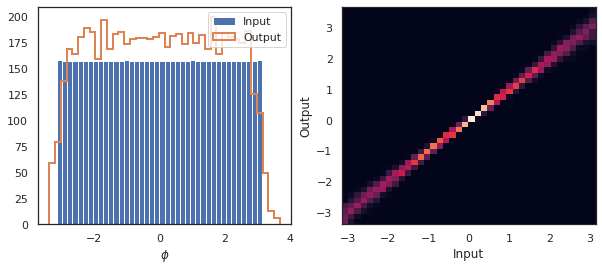

In [254]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(0,6)
plt.ylim(0,6)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')

plt.show()

This is successful, but after rerunning like 20 times.

# Linear Model MSE using SGD and optimal LR

In [44]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
        
model = MyModel()
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.e-1) # optimal LR obtained from LR finder below

   
train_data = MyDataset(dataset, dataset)
train_loader = DataLoader(dataset=train_data, batch_size=1000, shuffle=True)

for t in range(1000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = criterion(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))


Epoch 0: Loss: 3.3494937419891357.
Epoch 50: Loss: 0.7436863780021667.
Epoch 100: Loss: 0.33033230900764465.
Epoch 150: Loss: 0.0937718003988266.
Epoch 200: Loss: 0.20264247059822083.
Epoch 250: Loss: 0.12714901566505432.
Epoch 300: Loss: 0.13859671354293823.
Epoch 350: Loss: 0.12260140478610992.
Epoch 400: Loss: 0.11964821815490723.
Epoch 450: Loss: 0.1250724047422409.
Epoch 500: Loss: 0.07288738340139389.
Epoch 550: Loss: 0.08256921917200089.
Epoch 600: Loss: 0.1136634424328804.
Epoch 650: Loss: 0.13089783489704132.
Epoch 700: Loss: 0.0970800518989563.
Epoch 750: Loss: 0.12053538858890533.
Epoch 800: Loss: 0.14302095770835876.
Epoch 850: Loss: 0.09749257564544678.
Epoch 900: Loss: 0.11941619962453842.
Epoch 950: Loss: 0.09768913686275482.


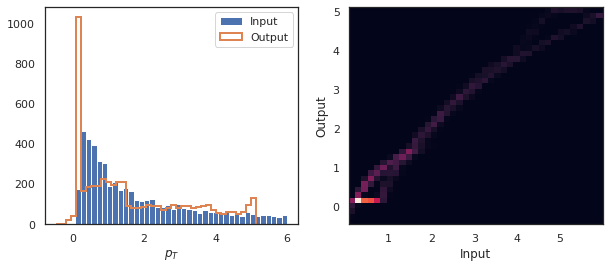

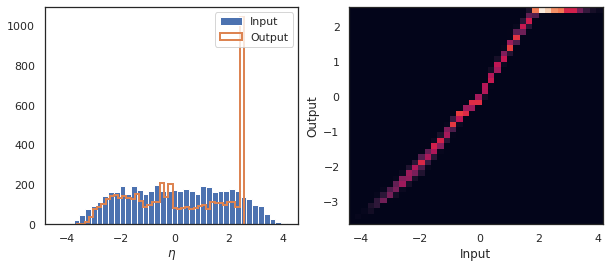

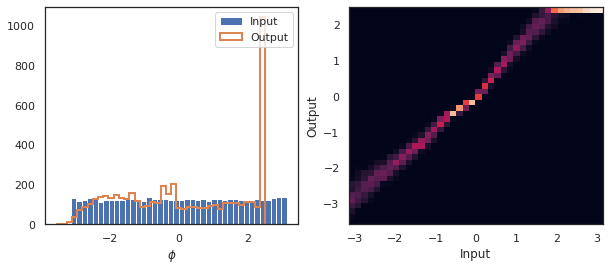

In [45]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(0,6)
plt.ylim(0,6)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')

plt.show()

# Linear Model MSE using SGD after N runs with optimal LR

In [59]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
        
model = MyModel()
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.e-1)

   
train_data = MyDataset(dataset, dataset)
train_loader = DataLoader(dataset=train_data, batch_size=1000, shuffle=True)

for t in range(1000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = criterion(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    for xval, yval in val_loader:
        y_pred = model(xval.float().cuda())
        label = yval.float().cuda()
        val_loss = criterion(label, y_pred)
        
    if t%50 == 0: print("Epoch {}: Loss: {:.3f}. Val Loss: {:.3f}".format(t, loss.item(), val_loss.item()))


Epoch 0: Loss: 4.268. Val Loss: 3.321
Epoch 50: Loss: 1.055. Val Loss: 1.025
Epoch 100: Loss: 0.325. Val Loss: 0.307
Epoch 150: Loss: 0.287. Val Loss: 0.232
Epoch 200: Loss: 0.235. Val Loss: 0.397
Epoch 250: Loss: 0.550. Val Loss: 0.347
Epoch 300: Loss: 0.321. Val Loss: 0.426
Epoch 350: Loss: 0.239. Val Loss: 0.415
Epoch 400: Loss: 0.150. Val Loss: 0.207
Epoch 450: Loss: 0.221. Val Loss: 0.337
Epoch 500: Loss: 0.202. Val Loss: 0.295
Epoch 550: Loss: 0.164. Val Loss: 0.192
Epoch 600: Loss: 0.210. Val Loss: 0.267
Epoch 650: Loss: 0.472. Val Loss: 0.409
Epoch 700: Loss: 0.266. Val Loss: 0.529
Epoch 750: Loss: 0.311. Val Loss: 0.535
Epoch 800: Loss: 0.249. Val Loss: 0.160
Epoch 850: Loss: 0.286. Val Loss: 0.415
Epoch 900: Loss: 0.456. Val Loss: 0.367
Epoch 950: Loss: 0.218. Val Loss: 0.261


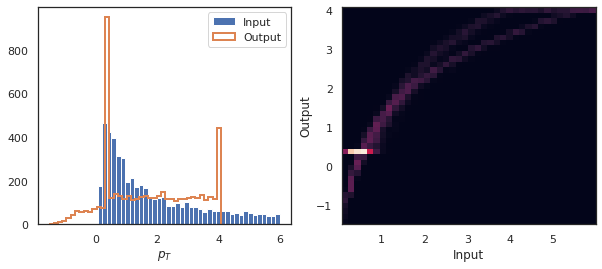

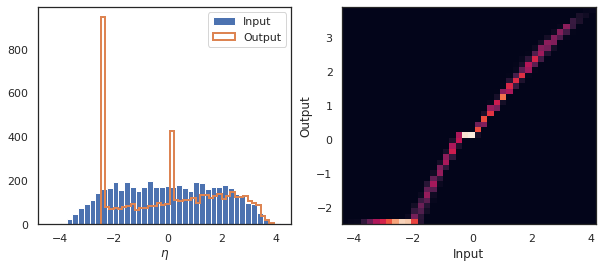

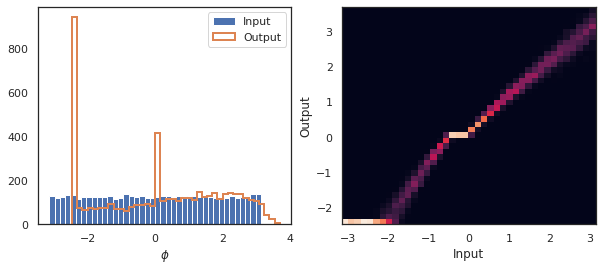

In [60]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(0,6)
plt.ylim(0,6)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')

plt.show()

# Linear Model MSE using Adam after N runs with optimal LR

In [50]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
        
model = MyModel()
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-1)

   
train_data = MyDataset(dataset, dataset)
train_loader = DataLoader(dataset=train_data, batch_size=1000, shuffle=True)

for t in range(1000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = criterion(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))


Epoch 0: Loss: 3.4984798431396484.
Epoch 50: Loss: 0.99308842420578.
Epoch 100: Loss: 0.797297477722168.
Epoch 150: Loss: 0.9379823803901672.
Epoch 200: Loss: 0.9200645089149475.
Epoch 250: Loss: 0.8929253816604614.
Epoch 300: Loss: 0.6305762529373169.
Epoch 350: Loss: 0.48532405495643616.
Epoch 400: Loss: 0.6258739829063416.
Epoch 450: Loss: 0.40575408935546875.
Epoch 500: Loss: 0.7807075381278992.
Epoch 550: Loss: 0.8831182718276978.
Epoch 600: Loss: 1.0034245252609253.
Epoch 650: Loss: 0.5710501074790955.
Epoch 700: Loss: 0.9407454133033752.
Epoch 750: Loss: 0.9922191500663757.
Epoch 800: Loss: 0.8092607855796814.
Epoch 850: Loss: 0.8506168127059937.
Epoch 900: Loss: 0.9463633894920349.
Epoch 950: Loss: 0.9936140179634094.


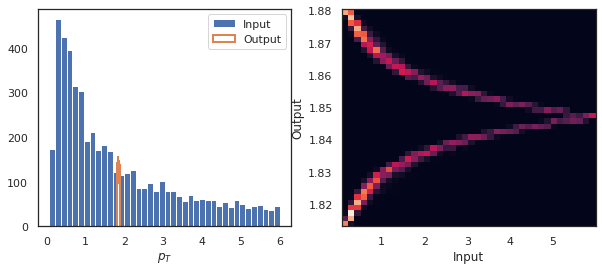

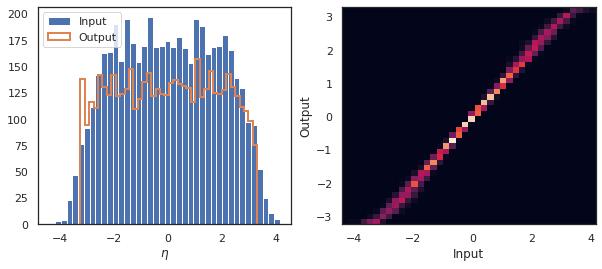

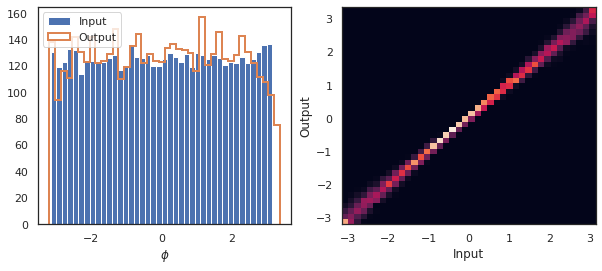

In [52]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(0,6)
plt.ylim(0,6)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')

plt.show()

Takeaway message: 
- Even a small AE is highly unstable and it's easy to get trapped into local minima. 
    - Can we escape this with 1-cycle training policy?


# One-cycle Learning Rate 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-01
Min loss divided by 10: 3.31E-01


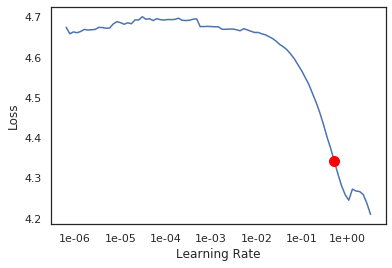

In [13]:
databunch = DataBunch(train_dl = train_loader, valid_dl = val_loader)

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
    
model = MyModel()
criterion = nn.MSELoss()

# Suppress printout progress -- FastAI has no easy way to do this
@dataclass
class SilenceRecorder(Callback):
    learn:Learner
    def __post_init__(self):
        self.learn.recorder.silent = True
learn = Learner(data = databunch, model = model, loss_func=criterion, callback_fns=[SilenceRecorder])
learn.lr_find(start_lr=1e-7, end_lr=10., num_it=100, stop_div=False)
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(500, min_grad_lr)

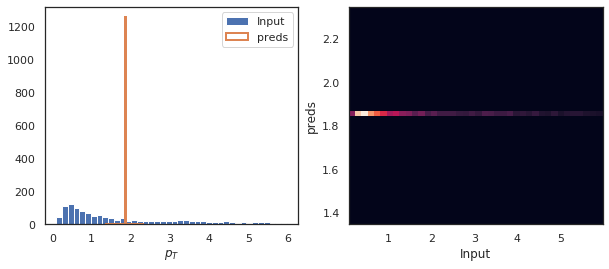

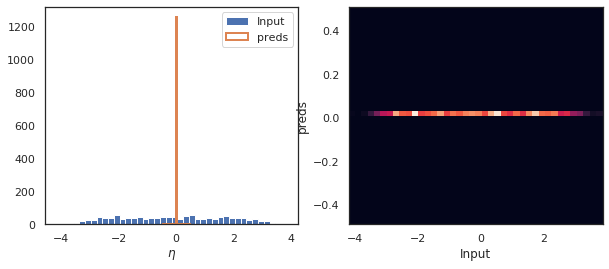

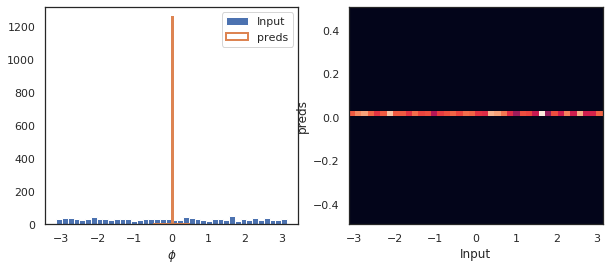

In [14]:
preds, y, losses = learn.get_preds(with_loss=True)
preds = preds.numpy()
y = y.numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y[:,0].flatten(),bins=40, label='Input')
plt.hist(preds[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='preds')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(y[:,0].flatten(),preds[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('preds')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y[:,1].flatten(),bins=40, label='Input')
plt.hist(preds[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='preds')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(y[:,1].flatten(),preds[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('preds')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y[:,2].flatten(),bins=40, label='Input')
plt.hist(preds[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='preds')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(y[:,2].flatten(),preds[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('preds')
plt.show()

So, no. One-cycle learning rate won't help stabilize autoencoders.

# Linear Model, Custom Loss mimicking MSE

In [15]:
def custom_loss(y_true, y_pred):
#     pt_loss = torch.pow(y_true[:,0].view(-1,1)-y_pred[:,0].view(-1,1),2)
#     eta_loss = torch.pow(y_true[:,1].view(-1,1)-y_pred[:,1].view(-1,1),2)
#     phi_loss = torch.pow(y_true[:,2].view(-1,1)-y_pred[:,2].view(-1,1),2)
    
#     return torch.sum(torch.sum((pt_loss+eta_loss+phi_loss), -1))
    return torch.mean(torch.sum(torch.pow(y_true-y_pred,2)))

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        self.decode_pt = nn.Linear(2,1)
        self.decode_eta = nn.Linear(2,1)
        self.decode_phi = nn.Linear(2,1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)
        pt = self.decode_pt(encoded)
        eta = self.decode_eta(encoded)
        phi = self.decode_phi(encoded)
        output = torch.cat((pt,eta,phi),1)
        return output
        
model = MyModel()
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

for t in range(500):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = custom_loss(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%20 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))





Epoch 0: Loss: 352.25634765625.
Epoch 20: Loss: 333.7437744140625.
Epoch 40: Loss: 263.6997985839844.
Epoch 60: Loss: 272.09674072265625.
Epoch 80: Loss: 151.84275817871094.
Epoch 100: Loss: 131.249755859375.
Epoch 120: Loss: 99.29679870605469.
Epoch 140: Loss: 57.57881546020508.
Epoch 160: Loss: 38.938636779785156.
Epoch 180: Loss: 32.87232208251953.
Epoch 200: Loss: 34.69673156738281.
Epoch 220: Loss: 37.06700134277344.
Epoch 240: Loss: 17.896663665771484.
Epoch 260: Loss: 10.354083061218262.
Epoch 280: Loss: 16.639854431152344.
Epoch 300: Loss: 19.907100677490234.
Epoch 320: Loss: 14.245565414428711.
Epoch 340: Loss: 12.163328170776367.
Epoch 360: Loss: 8.878170013427734.
Epoch 380: Loss: 11.088471412658691.
Epoch 400: Loss: 17.713516235351562.
Epoch 420: Loss: 6.7973785400390625.
Epoch 440: Loss: 6.184974670410156.
Epoch 460: Loss: 9.546875.
Epoch 480: Loss: 7.254382610321045.


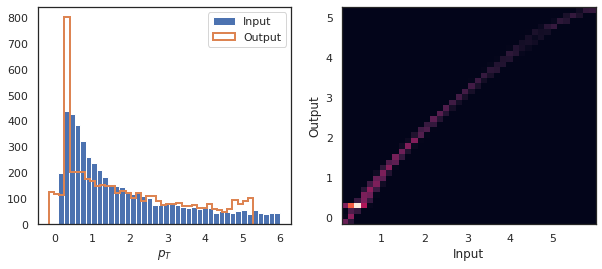

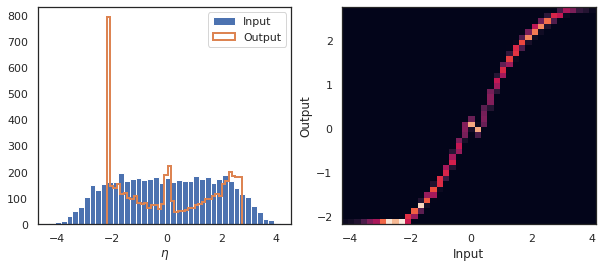

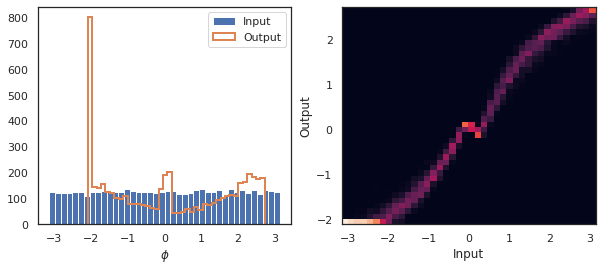

In [16]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

# Linear model, breaking down the loss and sum them over

In [179]:
def custom_loss(y_true, y_pred):
    pt_loss = torch.pow(y_true[:,0].view(-1,1)-y_pred[:,0].view(-1,1),2)
    eta_loss = torch.pow(y_true[:,1].view(-1,1)-y_pred[:,1].view(-1,1),2)
    phi_loss = torch.pow(y_true[:,2].view(-1,1)-y_pred[:,2].view(-1,1),2)
    
    return torch.mean(torch.sum((pt_loss+eta_loss+phi_loss), -1))
    
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        self.decode_pt = nn.Linear(2,1)
        self.decode_eta = nn.Linear(2,1)
        self.decode_phi = nn.Linear(2,1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)
        pt = self.decode_pt(encoded)
        eta = self.decode_eta(encoded)
        phi = self.decode_phi(encoded)
        output = torch.cat((pt,eta,phi),1)
        return output
        
model = MyModel()
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)
    
for t in range(5000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = custom_loss(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))





Epoch 0: Loss: 9.294410705566406.
Epoch 50: Loss: 6.485952377319336.
Epoch 100: Loss: 5.101860523223877.
Epoch 150: Loss: 3.6835362911224365.
Epoch 200: Loss: 1.6319019794464111.
Epoch 250: Loss: 1.700035572052002.
Epoch 300: Loss: 1.5214756727218628.
Epoch 350: Loss: 1.3379716873168945.
Epoch 400: Loss: 0.8186367750167847.
Epoch 450: Loss: 0.6725563406944275.
Epoch 500: Loss: 0.5237557888031006.
Epoch 550: Loss: 0.8654413223266602.
Epoch 600: Loss: 0.7130107283592224.
Epoch 650: Loss: 0.7023151516914368.
Epoch 700: Loss: 0.7232659459114075.
Epoch 750: Loss: 0.6699284315109253.
Epoch 800: Loss: 0.5922860503196716.
Epoch 850: Loss: 0.6718751192092896.
Epoch 900: Loss: 0.6852202415466309.
Epoch 950: Loss: 0.5727537274360657.
Epoch 1000: Loss: 0.9120477437973022.
Epoch 1050: Loss: 0.6892915368080139.
Epoch 1100: Loss: 0.6965158581733704.
Epoch 1150: Loss: 0.8055745959281921.
Epoch 1200: Loss: 0.6827384233474731.
Epoch 1250: Loss: 0.630942165851593.
Epoch 1300: Loss: 0.5720304250717163.
Ep

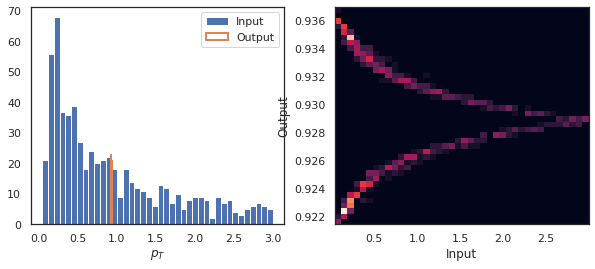

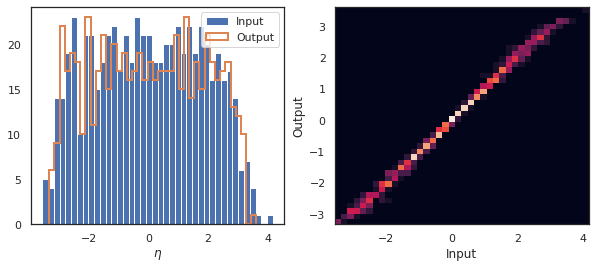

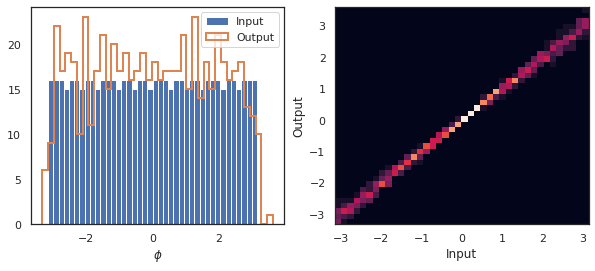

In [181]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

Now let's try with a custom loss, where $\phi$ loss is periodic and $\phi$ is bounded by ($-\pi, \pi$).

# Hardtanh $\phi$ bounded by $(-\pi, \pi)$, Periodic Loss

Now let's try with a custom loss, where $\phi$ loss is periodic and $\phi$ is bounded by ($-\pi, \pi$).

In [ ]:
def custom_loss(y_true, y_pred):
    pt_loss = torch.pow(y_true[:,0]-y_pred[:,0],2)
    eta_loss = torch.pow(y_true[:,1]-y_pred[:,1],2)
    def phi_mpi_pi(x):
        return (x < -np.pi).float() * (x + 2*np.pi) + (x >= np.pi).float() * (x - 2*np.pi)
    phi_loss = torch.pow(phi_mpi_pi(y_true[:,2]-y_pred[:,2]),2)
    
    return torch.sum(pt_loss+eta_loss+phi_loss)
    

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        self.decode_pt = nn.Linear(2,1)
        self.decode_eta = nn.Linear(2,1)
        self.decode_phi = nn.Linear(2,1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)
        pt = self.decode_pt(encoded)
        eta = self.decode_eta(encoded)
        phi = F.hardtanh(self.decode_phi(encoded), min_val = -np.pi, max_val = np.pi)
        output = torch.cat((pt,eta,phi),1)
        return output
        
model = MyModel()
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)
    
for t in range(1000):
    batch_loss =  []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = custom_loss(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))




Epoch 0: Loss: 253.60377502441406.
Epoch 50: Loss: 213.4369659423828.
Epoch 100: Loss: 207.8343048095703.
Epoch 150: Loss: 198.7028045654297.
Epoch 200: Loss: 237.27288818359375.
Epoch 250: Loss: 193.41424560546875.
Epoch 300: Loss: 230.99658203125.
Epoch 350: Loss: 203.60940551757812.
Epoch 400: Loss: 200.827880859375.
Epoch 450: Loss: 212.57586669921875.
Epoch 500: Loss: 162.01321411132812.
Epoch 550: Loss: 234.72532653808594.
Epoch 600: Loss: 169.69793701171875.
Epoch 650: Loss: 214.26023864746094.
Epoch 700: Loss: 192.04396057128906.
Epoch 750: Loss: 160.03045654296875.
Epoch 800: Loss: 222.31417846679688.
Epoch 850: Loss: 205.24838256835938.
Epoch 900: Loss: 194.32705688476562.


In [ ]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

Clearly doesn't work. How about we try with $\pi \sin(x)$?

# $\phi$ activated with $\pi\sin(x)$. MSE

In [17]:
def custom_loss(y_true, y_pred):
    pt_loss = torch.pow(y_true[:,0]-y_pred[:,0],2)
    eta_loss = torch.pow(y_true[:,1]-y_pred[:,1],2)
    phi_loss = torch.pow(y_true[:,2]-y_pred[:,2],2)
    
    return torch.sum(pt_loss+eta_loss+phi_loss)
    

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        self.decode_pt = nn.Linear(2,1)
        self.decode_eta = nn.Linear(2,1)
        self.decode_phi = nn.Linear(2,1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)
        pt = self.decode_pt(encoded)
        eta = self.decode_eta(encoded)
        phi = np.pi*torch.sin(self.decode_phi(encoded))
        output = torch.cat((pt,eta,phi),1)
        return output
        
model = MyModel()
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

for t in range(1000):
    batch_loss =  []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = custom_loss(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))




Epoch 0: Loss: 376.7373352050781.
Epoch 50: Loss: 239.0261993408203.
Epoch 100: Loss: 224.48655700683594.
Epoch 150: Loss: 224.00485229492188.
Epoch 200: Loss: 231.66502380371094.
Epoch 250: Loss: 213.21441650390625.
Epoch 300: Loss: 300.6123962402344.
Epoch 350: Loss: 290.818603515625.
Epoch 400: Loss: 264.80340576171875.
Epoch 450: Loss: 288.3147277832031.
Epoch 500: Loss: 190.10806274414062.
Epoch 550: Loss: 232.6136932373047.
Epoch 600: Loss: 257.732421875.
Epoch 650: Loss: 270.56304931640625.
Epoch 700: Loss: 221.7354736328125.
Epoch 750: Loss: 254.87307739257812.
Epoch 800: Loss: 186.55149841308594.
Epoch 850: Loss: 312.62689208984375.
Epoch 900: Loss: 288.050537109375.
Epoch 950: Loss: 258.45037841796875.


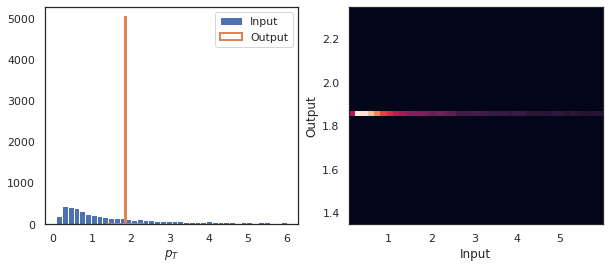

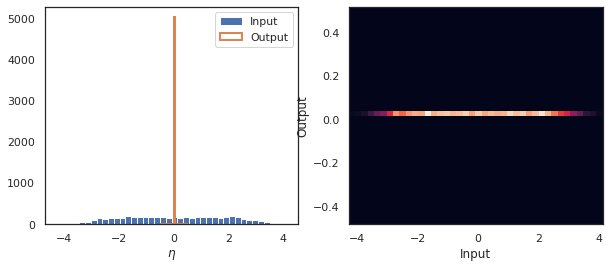

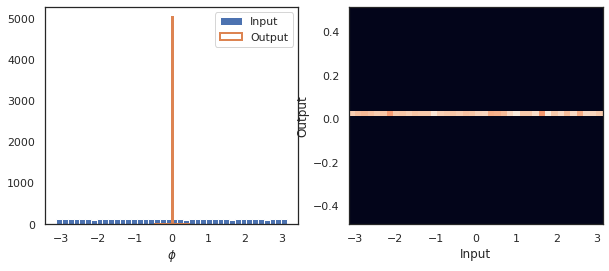

In [18]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

# Takeaway messages

- Even a simple autoencoders is hard to train because of stability.
- Cyclical learning rate doesn't help.
- Adam/SGD doesn't help.
- Optimal learning rate doesn't help.
- Be patient and praying might help.